<a href="https://colab.research.google.com/github/BrilliantChard/Python-and-ML/blob/main/Racial_Bias_in_risk_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install aif360
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 15.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

pip install 'aif360[inFairness]'


In [ ]:
# Loading and inspect dataset
# dataset_orig = CompasDataset()
# dataset_orig.convert_to_dataframe()[0].head()

from google.colab import drive
drive.mount("/content/drive")

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/compas.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [ ]:
data = data[(data.days_b_screening_arrest <= 30) &
        (data.days_b_screening_arrest >= -30) &
        (data.is_recid != -1) &
        (data.c_charge_degree != 'O') &
        (data.score_text != 'N/A')]

In [ ]:
data['race'] = data['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)
data['sex'] = data['sex'].apply(lambda x: 1 if x == 'Male' else 0)
data['label'] = data['two_year_recid']

In [ ]:
features = ['age', 'sex', 'priors_count', 'race']
label_name = 'label'

In [ ]:
# Create BinaryLabelDataset

from aif360.datasets import BinaryLabelDataset
dataset = BinaryLabelDataset(df=data[features + [label_name]],
                             label_names=[label_name],
                             protected_attribute_names=['race'])

In [ ]:
# Reweighing
privileged = [{'race': 1}]  # Caucasian
unprivileged = [{'race': 0}]  # African-American
RW = Reweighing(unprivileged_groups=unprivileged, privileged_groups=privileged)
dataset_transf = RW.fit_transform(dataset)

In [ ]:
# Train/Test model
X = dataset.features
y = dataset.labels.ravel()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

In [ ]:
# Evaluation
pred_dataset = dataset.copy()
pred_dataset.labels = y_pred

In [ ]:
metric = ClassificationMetric(dataset, pred_dataset,
                              unprivileged_groups=unprivileged,
                              privileged_groups=privileged)

In [ ]:
print("False Positive Rate (Unpriv):", metric.false_positive_rate(privileged=False))
print("False Positive Rate (Priv):", metric.false_positive_rate(privileged=True))
print("Equal Opportunity Diff:", metric.equal_opportunity_difference())
print("Average Odds Diff:", metric.average_odds_difference())

False Positive Rate (Unpriv): 0.23967339097022095
False Positive Rate (Priv): 0.13505074160811867
Equal Opportunity Diff: 0.2117780169642824
Average Odds Diff: 0.15820033316319232


In [ ]:
# Visualization
fpr_priv = metric.false_positive_rate(privileged=True)
fpr_unpriv = metric.false_positive_rate(privileged=False)

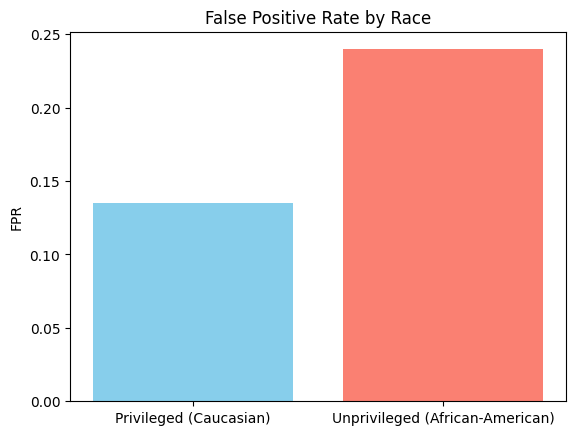

In [ ]:
plt.bar(['Privileged (Caucasian)', 'Unprivileged (African-American)'],
        [fpr_priv, fpr_unpriv], color=['skyblue', 'salmon'])
plt.title("False Positive Rate by Race")
plt.ylabel("FPR")
plt.show()